# Test d'inférence de la première version entraînée du GNN (sans critères "physics informed")

## 1. Définition des chemins des fichiers (à ajuster selon votre environnement local)

In [1]:
model_file_path = "C:\\Repos\\GIF-7005-Project\\model_25-11-25\\model.pth"
scaler_file_path = "C:\\Repos\\GIF-7005-Project\\model_25-11-25\\scaler.joblib"
dataset_path = "data/body_coordinates_and_velocities_from_1749-12-31_to_2200-01-09.json"

## 2. Chargement des librairies

In [14]:
from model.GNN import GNN_NBody, InteractionNetwork
from data import solarSystemDataSet
import torch
from torch_geometric.data import Data
import torch_geometric.nn
import torch_geometric.inspector
import inspect
import _operator
import typing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import load
import matplotlib.pyplot as plt

## 3. Chargement du modèle

In [3]:
torch.serialization.add_safe_globals(
    [
        GNN_NBody, 
        torch.nn.modules.linear.Linear, 
        torch.nn.modules.container.ModuleList, 
        InteractionNetwork, 
        torch_geometric.nn.aggr.basic.SumAggregation, 
        torch.nn.modules.container.Sequential,
        torch.nn.modules.activation.ReLU,
        torch_geometric.inspector.Inspector,
        torch_geometric.inspector.Signature,
        torch_geometric.inspector.Parameter,
        inspect._empty,
        _operator.getitem,
        typing.OrderedDict,
        typing.Union,
        type,
        int
    ])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model: GNN_NBody = torch.load(model_file_path, map_location=torch.device('cpu'))

model.eval()
model.to(device)

Using device: cpu


GNN_NBody(
  (node_encoder): Linear(in_features=7, out_features=128, bias=True)
  (interaction_layers): ModuleList(
    (0-2): 3 x InteractionNetwork()
  )
  (output_decoder): Linear(in_features=128, out_features=6, bias=True)
)

## 4. Chargement du scaler et du jeu de données

In [4]:
# Chargement du scaler sauvegardé.
scaler: StandardScaler = load(scaler_file_path)

# Chargement des données de référence dans un DataFrame.
df_targets: pd.DataFrame = pd.read_json(dataset_path, lines=True)

c:\Repos\GIF-7005-Project\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 5. Tests d'inférence avec le modèle

In [21]:
# Pour les fins du test, on ne conserve que les données pour l'année 2025.
df_targets_2025 = df_targets[(df_targets["datetime_str"].str.startswith("A.D. 2025-"))]
df_targets_2025['body_mass'] = np.log10(df_targets_2025['body_mass'])

X_dataset: solarSystemDataSet.SolarSystemDataset = solarSystemDataSet.SolarSystemDataset(df_targets_2025, scaler)

df_predictions_2025: pd.DataFrame = pd.DataFrame()

DELTA_SCALER = 1000.0

# On part l'inférence à partir des positions et vélocitées des planètes le 1er janvier 2025.
current_pos_and_velocities = X_dataset.states[0]

with torch.no_grad():
    for day_index in range(len(X_dataset.states)):
        state_numpy = current_pos_and_velocities.numpy()

        # On ne garde que la dernière colonne, qui correspond à la masse des planètes normalisée par le scaler.
        normalized_body_masses = state_numpy[:, -1:]

        # Prédiction des features pour l'ensemble des corps (delta de positions et de vélocités).
        predicted_deltas_normalized = model(Data(x=current_pos_and_velocities, edge_index=X_dataset.edge_index))

        # "predicted_deltas_normalized" est de shape (9, 6), mais on veut l'additionner aux valeurs de "current_pos_and_velocities", de shape (9, 7).
        # On ajoute donc une colonne de zéros pour que les shapes soient compatibles et pour pouvoir faire l'addition.
        current_pos_and_velocities += torch.tensor(np.append(predicted_deltas_normalized.numpy(), np.zeros((9, 1)), axis=1)) / DELTA_SCALER

        # On dénormalise les valeurs et on les ajoute au DataFrame des prédictions.
        predicted_pos_and_velocities_norm_numpy = current_pos_and_velocities.numpy()
        predicted_pos_and_velocities_denorm = scaler.inverse_transform(predicted_pos_and_velocities_norm_numpy)

        # On transforme les prédictions dénormalisées en DataFrame et on ajoute à celui-ci une colonne pour identifier le jour associé à la prédiction.
        df_day_predictions: pd.DataFrame = pd.DataFrame(predicted_pos_and_velocities_denorm)
        df_day_predictions.insert(loc=0, column="day", value=np.full((9, 1), day_index, dtype=int))

        df_predictions_2025 = pd.concat([df_predictions_2025, df_day_predictions], ignore_index=True)

df_predictions_2025.columns = ['day', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'body_mass']
df_predictions_2025.to_json('predicted_body_coordinates_and_velocities_from_2025-01-01_to_2025-12-31.json', orient='records', lines=True)

C:\Users\alpha\AppData\Local\Temp\ipykernel_62616\3685467593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets_2025['body_mass'] = np.log10(df_targets_2025['body_mass'])
Processing data groups: 100%|██████████| 365/365 [00:00<00:00, 1595.38it/s]


In [34]:
display(df_predictions_2025.head(9))
display(df_targets_2025.head(9))

,day,x,y,z,vx,vy,vz,body_mass
0,0,-0.005726,-0.004943,0.000179,0.000007,-0.000004,-1.188103e-07,30.298634
1,0,-0.387284,-0.190800,0.019951,0.006539,-0.024066,-2.565210e-03,23.518658
2,0,0.431561,0.569964,-0.017166,-0.016148,0.012162,1.099073e-03,24.687305
3,0,-0.201583,0.958766,0.000123,-0.017140,-0.003498,-4.519504e-08,24.776146
4,0,-0.540055,1.517008,0.045180,-0.012667,-0.003450,2.385009e-04,23.807339
5,0,1.042740,4.968322,-0.043937,-0.007472,0.001910,1.592788e-04,27.278341
6,0,9.455904,-1.764188,-0.345799,0.000714,0.005472,-1.231806e-04,26.754608
7,0,11.094573,16.091551,-0.083970,-0.003267,0.002049,4.997300e-05,25.938570
8,0,29.873404,-0.635176,-0.675288,0.000048,0.003156,-6.646549e-05,26.010355


,body_id,body_name,body_mass,datetime_jd,datetime_str,x,y,z,vx,vy,vz
100443,10,Soleil,30.298635,2460676.5,A.D. 2025-Jan-01 00:00:00.0000,-0.005731,-0.004911,0.000180,0.000007,-0.000004,-1.177000e-07
100444,10,Soleil,30.298635,2460677.5,A.D. 2025-Jan-02 00:00:00.0000,-0.005723,-0.004914,0.000179,0.000007,-0.000004,-1.178000e-07
100445,10,Soleil,30.298635,2460678.5,A.D. 2025-Jan-03 00:00:00.0000,-0.005716,-0.004918,0.000179,0.000007,-0.000004,-1.180000e-07
100446,10,Soleil,30.298635,2460679.5,A.D. 2025-Jan-04 00:00:00.0000,-0.005709,-0.004922,0.000179,0.000007,-0.000004,-1.181000e-07
100447,10,Soleil,30.298635,2460680.5,A.D. 2025-Jan-05 00:00:00.0000,-0.005702,-0.004925,0.000179,0.000007,-0.000004,-1.183000e-07
100448,10,Soleil,30.298635,2460681.5,A.D. 2025-Jan-06 00:00:00.0000,-0.005695,-0.004929,0.000179,0.000007,-0.000004,-1.184000e-07
100449,10,Soleil,30.298635,2460682.5,A.D. 2025-Jan-07 00:00:00.0000,-0.005688,-0.004932,0.000179,0.000007,-0.000004,-1.186000e-07
100450,10,Soleil,30.298635,2460683.5,A.D. 2025-Jan-08 00:00:00.0000,-0.005680,-0.004936,0.000179,0.000007,-0.000004,-1.187000e-07
100451,10,Soleil,30.298635,2460684.5,A.D. 2025-Jan-09 00:00:00.0000,-0.005673,-0.004939,0.000179,0.000007,-0.000004,-1.189000e-07


## 6. Traçage des trajectoires prédites des planètes et comparaison avec les valeurs attendues

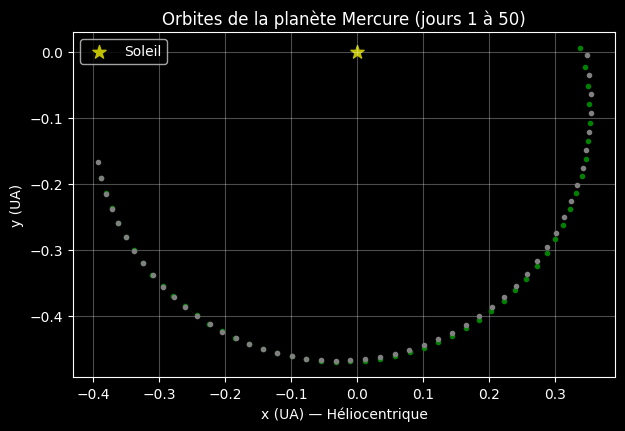

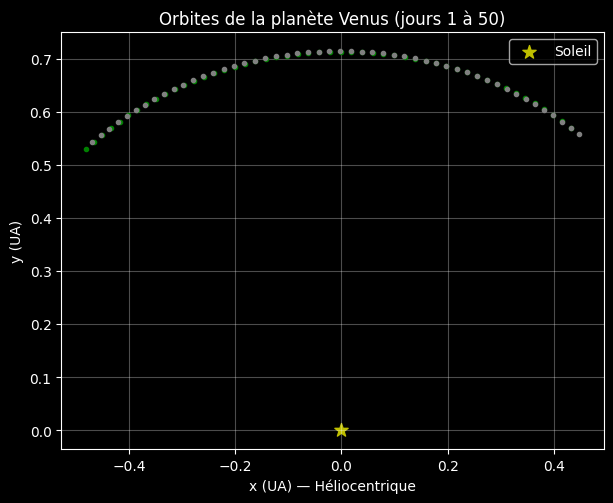

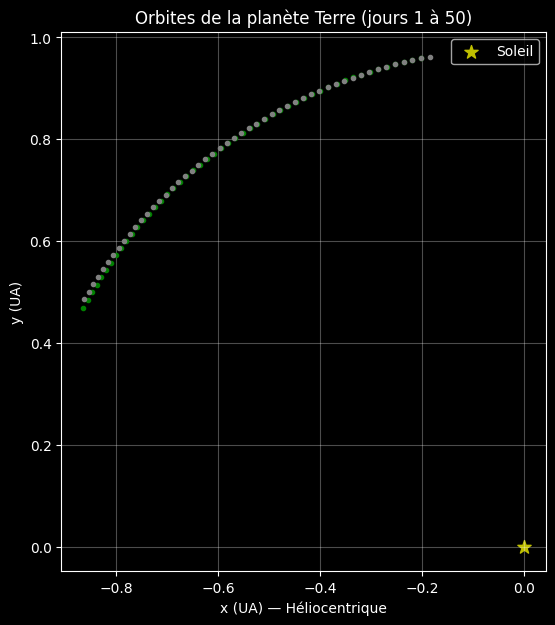

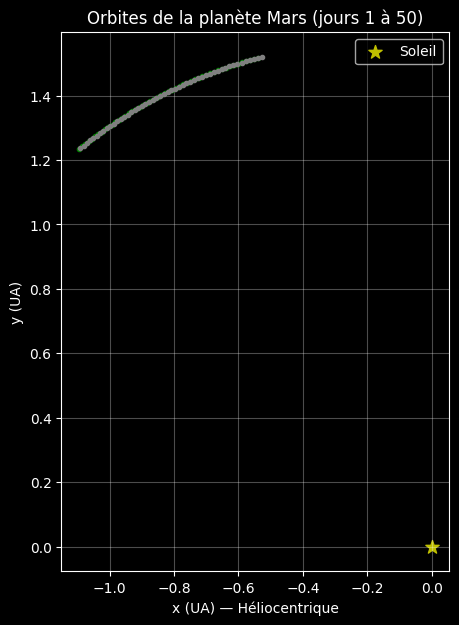

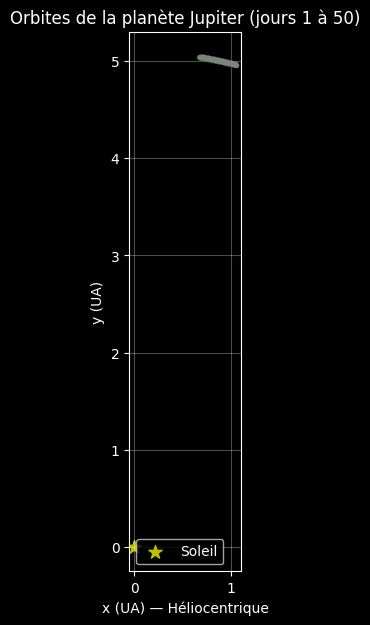

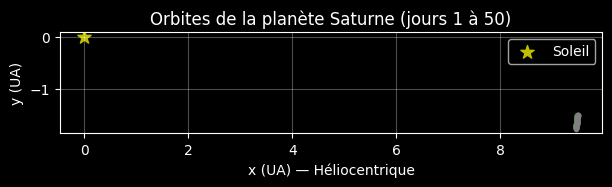

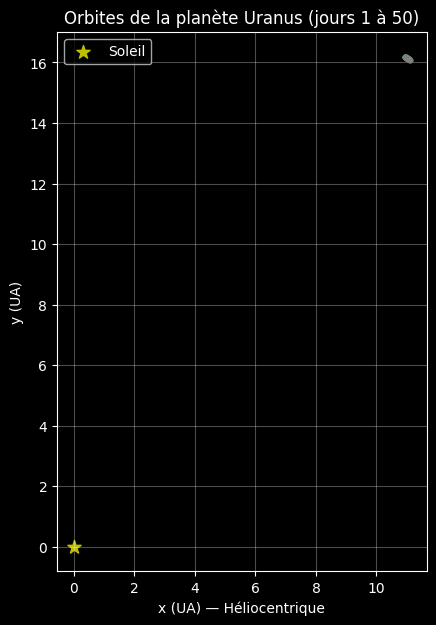

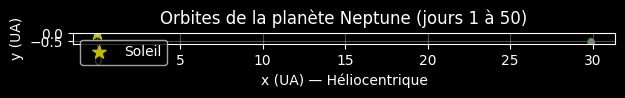

In [47]:
num_days: int = 50

planet_masses: dict[str, float] = {
    "Mercure": 23.518657684326172,
    "Venus": 24.687305450439453,
    "Terre": 24.776145935058594,
    "Mars": 23.80733871459961,
    "Jupiter": 27.27834129333496,
    "Saturne": 26.754608154296875,
    "Uranus": 25.938570022583008,
    "Neptune": 26.01035499572754
}

for planet_name in list(planet_masses.keys()):
    planet_mass: float = planet_masses[planet_name]
    df_planet_prediction: pd.DataFrame = df_predictions_2025[(df_predictions_2025["day"] < num_days) & (df_predictions_2025["body_mass"] == planet_mass)]
    df_planet_target: pd.DataFrame = df_targets_2025[(df_targets_2025["datetime_jd"] < 2460676.5 + num_days) & (df_targets_2025["body_name"] == planet_name)]

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(df_planet_prediction["x"], df_planet_prediction["y"], ".g")
    ax.plot(df_planet_target["x"], df_planet_target["y"], marker=".", ls="None", color="gray")

    ax.scatter([0], [0], marker="*", s=100, label="Soleil", color="y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x (UA) — Héliocentrique")
    ax.set_ylabel("y (UA)")
    ax.set_title(f"Orbites de la planète {planet_name} (jours 1 à {num_days})")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2)
    plt.show()